In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
import corner

In [3]:

from agnfinder.tf_sampling.hmc import hmc

In [4]:
tf.enable_eager_execution()

In [5]:
os.chdir('/home/mike/repos/agnfinder')

In [6]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [7]:
# dist = tfd.MultivariateNormalDiag(
#       loc=[.3, .7],
#       scale_diag=[0.3, 0.3])
# dist.mean().numpy()

# two slightly overlapping 2D Gaussians
dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5, 0.5]),
    components_distribution=tfd.MultivariateNormalDiag(
    loc=[[.8, .5], [.2, .5]],
    scale_diag=[[.2, .4], [.2, .4]])
)


Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.


In [8]:
x = tf.constant(np.random.rand(10, 2), dtype=tf.float32)
print(x.shape)
dist.prob(x).numpy()

(10, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


array([0.525205  , 0.64501256, 0.5750485 , 0.76779926, 0.59899855,
       0.5085987 , 0.46469867, 0.7004181 , 0.41071293, 0.7651859 ],
      dtype=float32)

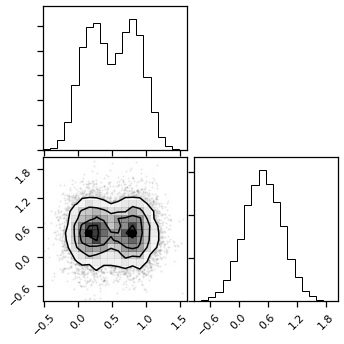

In [9]:
exact_samples = dist.sample(10000)
_ = corner.corner(exact_samples)

In [10]:

log_prob = dist.log_prob
 
n_chains = 30
# initial_state = tf.constant([0.1, 0.15, 0.2])
initial_state = tf.constant(np.random.rand(n_chains, 2), dtype=tf.float32)
num_results = 1000
num_burnin = 100

In [11]:
log_prob(initial_state).numpy()

array([-0.7001086 , -0.36766374, -0.37105322, -0.22436115, -0.1366634 ,
       -0.54186726, -0.8059835 , -0.9014059 , -0.27437976, -0.10728722,
       -0.12938754, -0.4076832 , -0.17822838, -0.39219737, -0.8279581 ,
       -0.10977706, -0.6566893 , -0.9756292 , -0.05134938, -0.01766942,
        0.00360163, -0.28426957, -0.4022646 , -0.69768685, -0.6627469 ,
       -0.38878882, -0.4842312 , -0.14214313, -0.03804886, -0.548657  ],
      dtype=float32)

In [12]:
step_size = .01
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=log_prob,
    step_size=step_size
)
# step_size=tf.fill([n_chains, 2], step_size)  # should be same shape as initial_state for each chain to have own step size. Same step size per variable, though??

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=3,
    step_size=step_size
)

#     step_size=tf.fill([n_chains, 2], step_size)

In [30]:
hmc_adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc_kernel,
    num_adaptation_steps=int(num_burnin * 0.8)
)

# https://github.com/tensorflow/probability/issues/549
nuts_adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    nuts_kernel,
    num_adaptation_steps=int(num_burnin * 0.8),
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
    step_size_getter_fn=lambda pkr: pkr.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
)

In [31]:
# initial_state.shape

In [33]:
start_time = datetime.datetime.now()

chain_output = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin,
    current_state=initial_state,
    kernel=hmc_adaptive_kernel,
    trace_fn=None
)

time_elapsed = datetime.datetime.now() - start_time
print(f'HMC sampling complete in {time_elapsed}')
#     https://github.com/tensorflow/probability/blob/f90448698cc2a16e20939686ef0d5005aad95f29/tensorflow_probability/python/mcmc/nuts.py#L72
#     trace_fn=lambda _, prev_kernel_results: {'is_accepted': prev_kernel_results.inner_results.is_accepted, 'step_size': prev_kernel_results.inner_results.step_size}

HMC sampling complete in 0:00:45.788683


In [19]:
start_time = datetime.datetime.now()

chain_output = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin,
    current_state=initial_state,
    kernel=nuts_adaptive_kernel,
    trace_fn=None
)

time_elapsed = datetime.datetime.now() - start_time
print(f'NUTS sampling complete in {time_elapsed}')

Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.


NUTS sampling complete in 0:04:12.311293


In [21]:
type(chain_output)
samples = chain_output
samples = samples.numpy()

In [22]:
# trace['step_size']

In [24]:
# is_accepted = trace['is_accepted'].numpy()
# step_size = trace['step_size'][0].numpy()

In [25]:
# trace['step_size'][0][1]

In [ ]:
# is_accepted

In [ ]:
# is_accepted.mean()

In [ ]:
# step_size.min(), step_size.max()

In [ ]:
# samples.shape

In [26]:
reshaped = samples.squeeze().reshape(-1, 2)
reshaped.shape

(30000, 2)

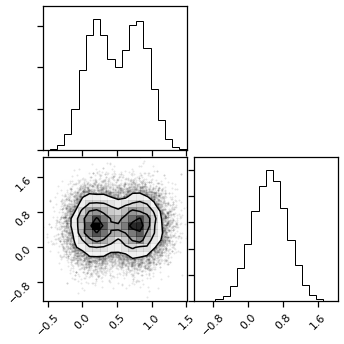

In [27]:

_ = corner.corner(reshaped)

In [ ]:
# for n in range(len(initial_state)):
#     plt.hist(samples[:, n], alpha=0.4, density=True)
# x = np.linspace(-9, 9)
# plt.plot(x, dist.prob(x).numpy())

In [ ]:
samples, trace = hmc(log_prob, initial_state, num_results, num_burnin)

In [ ]:
reshaped = samples.numpy().squeeze().reshape(-1, 2)
reshaped.shape
_ = corner.corner(reshaped)